## Multiclass Segmentation - Oxford Pets

## Modules

In [1]:
import os
import sys

common_dir = os.path.abspath("../../common")
print(os.listdir(common_dir))

if common_dir not in sys.path:
    sys.path.append(common_dir)

['pt_trainer.py', 'tf_trainer.py', 'utils.py', '__pycache__']


In [2]:
import tensorflow as tf
from tensorflow import keras

import random
import numpy as np
import matplotlib.pyplot as plt

from utils import show_images, plot_progress
from tf_trainer import TrainerWithMetrics, TrainerWithEarlyStopping
from tf_trainer import accuracy, binary_accuracy
from scipy.special import softmax, expit as sigmoid

os.environ["TF_CPP_MIN_LOG_LEVEL"] = '3'

## Parameters

In [3]:
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [4]:
image_size = (224, 224)
batch_size = 32

save_weights = False
weights_name = "./tf_models/tf_oxford-pets_seg-3.h5"

## Data Set

In [5]:
from glob import glob
import re
from sklearn.preprocessing import LabelEncoder
from collections import Counter

def get_paths(image_dir, formats=["*"]):
    invalid_images = ['Egyptian_Mau_14',  'Egyptian_Mau_139', 'Egyptian_Mau_145',
                      'Egyptian_Mau_156', 'Egyptian_Mau_167', 'Egyptian_Mau_177',
                      'Egyptian_Mau_186', 'Egyptian_Mau_191', 'Abyssinian_5',
                      'Abyssinian_34',    'chihuahua_121',    'beagle_116']
    paths = []
    for ext in formats:
        paths += glob(os.path.join(image_dir, f"*.{ext}"))

    valid_paths = []
    for path in paths:
        image_name = os.path.basename(path).split('.')[0]
        if image_name not in invalid_images:
            valid_paths.append(path)
    return valid_paths

def get_labels(image_paths, n_classes=37):
    image_names = [os.path.basename(path).split('.')[0] for path in image_paths]
    if n_classes == 2:
        labels = ['cat' if name[0].isupper() else 'dog' for name in image_names]
    else:
        labels = [re.sub('_\d+', '', name) for name in image_names]
    return labels

def get_class_names(labels):
    return list(Counter(labels).keys())

def label_encoder(labels, class_names):
    encoder = {name: i for i, name in enumerate(class_names)}
    return [encoder[label] for label in labels]

In [6]:
def change_paths(new_dir, old_paths, replace=("ext1", "ext2")):
    filenames = [os.path.basename(path).replace(replace[0], replace[1])
                 for path in old_paths]
    return [os.path.join(new_dir, name) for name in filenames]

In [7]:
data_dir = "/mnt/f/deep_learning/datasets/oxford_pets_783M/"
image_dir = os.path.join(data_dir, "images")
mask_dir = os.path.join(data_dir, "annotations", "trimaps")

image_paths = get_paths(image_dir, formats=['jpg'])
labels = get_labels(image_paths, n_classes=37)
class_names = get_class_names(labels)
labels = label_encoder(labels, class_names)

print(f">> Images: {len(image_paths)}")
print(">> Class Names:", class_names)

>> Images: 7378
>> Class Names: ['Abyssinian', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'Bengal', 'Birman', 'Bombay', 'boxer', 'British_Shorthair', 'chihuahua', 'Egyptian_Mau', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'Maine_Coon', 'miniature_pinscher', 'newfoundland', 'Persian', 'pomeranian', 'pug', 'Ragdoll', 'Russian_Blue', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'Siamese', 'Sphynx', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


In [8]:
from sklearn.model_selection import train_test_split

train_image_paths, test_image_paths, train_labels, test_labels = train_test_split(
    image_paths, labels, stratify=labels, train_size=0.8, random_state=seed)

train_image_paths, valid_image_paths, train_labels, valid_labels = train_test_split(
    train_image_paths, train_labels, stratify=train_labels, train_size=0.75, random_state=seed)

train_mask_paths = change_paths(mask_dir, train_image_paths, replace=['jpg', 'png'])
valid_mask_paths = change_paths(mask_dir, valid_image_paths, replace=['jpg', 'png'])
test_mask_paths = change_paths(mask_dir, test_image_paths, replace=['jpg', 'png'])

n_images = len(image_paths)
print(f">> Train images: {len(train_image_paths)} ({len(train_image_paths)/n_images:.2f})")
print(f">> Valid images: {len(valid_image_paths)} ({len(valid_image_paths)/n_images:.2f})")
print(f">> Test  images: {len(test_image_paths)} ({len(test_image_paths)/n_images:.2f})")

>> Train images: 4426 (0.60)
>> Valid images: 1476 (0.20)
>> Test  images: 1476 (0.20)


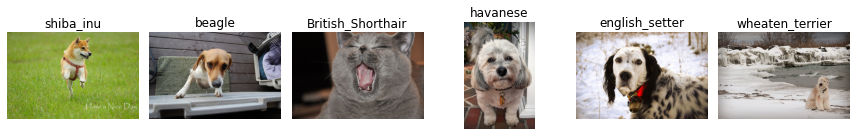

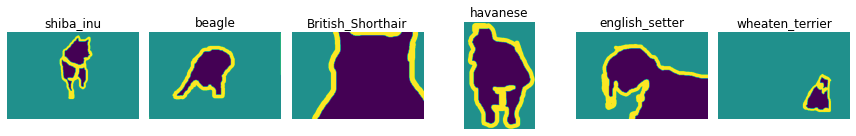

In [9]:
n_samples = 6
show_images(train_image_paths[:n_samples], labels=train_labels[:n_samples], 
            class_names=class_names, n_cols=6)
show_images(train_mask_paths[:n_samples], labels=train_labels[:n_samples], 
            class_names=class_names, n_cols=6)

## Data Loader

In [10]:
import albumentations as A
from functools import partial

@tf.function
def load_data(image_path, mask_path):
    image = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(image, channels=3)

    mask = tf.io.read_file(mask_path)
    mask = tf.io.decode_png(mask, channels=1)
    return image, mask

def augmenation(image, mask, training):
    transform = train_transform if training else valid_transform
    transformed = transform(image=image, mask=mask)
    image = transformed['image']
    mask = transformed['mask']

    # image = tf.cast(image, dtype=tf.float32)/255
    image = tf.cast(image, dtype=tf.float32)
    mask -= 1
    mask = tf.squeeze(mask)
    mask = tf.one_hot(mask, depth=3)
    mask = tf.cast(mask, dtype=tf.float32)
    return image, mask

@tf.function
def preprocess(image, mask, training):
    image, mask = tf.numpy_function(augmenation,
                        inp=[image, mask, training],
                        Tout=[tf.float32, tf.float32])
    return image, mask

def get_dataloader(image_paths, mask_paths, batch_size, training, shuffle=True):
    AUTOTUNE = tf.data.experimental.AUTOTUNE
    dataloader = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths)).cache()
    dataloader = dataloader.map(load_data, num_parallel_calls=AUTOTUNE)
    dataloader = dataloader.map(partial(preprocess, training=training),
                                num_parallel_calls=AUTOTUNE)
    if shuffle:
        dataloader = dataloader.shuffle(1000)
    dataloader = dataloader.batch(batch_size).prefetch(AUTOTUNE)
    return dataloader

train_transform = A.Compose([
    A.Resize(height=image_size[0], width=image_size[1]),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(p=0.5, shift_limit=0.05, scale_limit=0.05, rotate_limit=15,),
    A.CoarseDropout(p=0.5, max_holes=8, max_height=int(0.1*image_size[0]), 
                    max_width=int(0.1*image_size[1])),
    # A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ])
valid_transform = A.Compose([
    A.Resize(height=image_size[0], width=image_size[1]),
    # A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ])

train_loader = get_dataloader(train_image_paths, train_mask_paths, 
                              batch_size, training=True, shuffle=True)
valid_loader = get_dataloader(valid_image_paths, valid_mask_paths, 
                              batch_size, training=False, shuffle=True)
test_loader = get_dataloader(test_image_paths, test_mask_paths, 
                             batch_size, training=False, shuffle=True)

In [11]:
images, masks = next(iter(train_loader))
print(type(images), images.shape, images.dtype)
print(type(masks), masks.shape, masks.dtype)

# images = images.numpy().astype(int)
# masks = masks.numpy()

# n_samples = 6
# print(f">> Images: min: {images.min()}, max: {images.max()}")
# print(f">> Labels: min: {masks.min()}, max: {masks.max()}")
# show_images(images[:n_samples], n_cols=6)
# show_images(masks[:n_samples], n_cols=6)

<class 'tensorflow.python.framework.ops.EagerTensor'> (32, 224, 224, 3) <dtype: 'float32'>
<class 'tensorflow.python.framework.ops.EagerTensor'> (32, 224, 224, 3) <dtype: 'float32'>


## Modeling

In [21]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import UpSampling2D

def conv_block(x, out_channels):
    x = layers.Conv2D(out_channels, kernel_size=3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(out_channels, kernel_size=3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

def upsample(x, out_channels):
    x = layers.UpSampling2D(size=2)(x)
    x = layers.Conv2D(out_channels, kernel_size=1, padding='same')(x)
    # x = layers.Conv2DTranspose(out_channels, kernel_size=2, strides=2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

def custom_unet(input_shape, out_channels, filters=[32, 64, 128, 256]):
    inputs = keras.Input(input_shape)
    x = layers.Conv2D(3, kernel_size=1, padding='same')(inputs)

    ## Down-sampling
    features = []
    for filter in filters:
        x = conv_block(x, filter)
        features.append(x)
        x = layers.MaxPooling2D(pool_size=2)(x)

    ## Bridge
    x = conv_block(x, filters[-1]*2)

    ## Up-sampling
    for filter, feature in zip(filters[::-1], features[::-1]):
        x = upsample(x, filter)
        x = layers.Concatenate(axis=-1)([x, feature])
        x = conv_block(x, filter)

    outputs = layers.Conv2D(out_channels, kernel_size=1, padding='same', activation='softmax')(x)
    return keras.Model(inputs=inputs, outputs=outputs)

In [22]:
import segmentation_models as sm

def get_pretrained_unet(model_name, input_shape, n_classes, freezed=True):
    preprocess_input = sm.get_preprocessing(model_name)
    model = sm.Unet(model_name, 
                    input_shape=input_shape, classes=3,
                    encoder_weights='imagenet',
                    encoder_freeze=freezed,
                    activation='softmax')

    inputs = keras.Input(input_shape)
    x = preprocess_input(inputs)
    outputs = model(x)
    return keras.Model(inputs, outputs)

## Training

In [24]:
%%time
keras.backend.clear_session()

@tf.autograph.experimental.do_not_convert
def acc(y_true, y_pred):
    y_pred = tf.round(y_pred)
    return tf.reduce_mean(tf.cast(tf.equal(y_true, y_pred), tf.float32))

# model = get_pretrained_unet('efficientnetb4', input_shape=(224, 224, 3), n_classes=3, freezed=True)
model = custom_unet(input_shape=(224, 224, 3), out_channels=3)
optimizer = keras.optimizers.Adam()
loss_fn = sm.losses.DiceLoss()
metrics = {'iou': sm.metrics.IOUScore(), 'f': sm.metrics.FScore(), 'acc': acc}

clf = TrainerWithEarlyStopping(model, optimizer, loss_fn, metrics)
hist = clf.fit(train_loader, n_epochs=3, valid_loader=valid_loader)

results = clf.evaluate(test_loader)
print(">>", ', '.join([f"test_{key}={value:.4f}" 
                       for key, value in results.items()]))

Epoch[  1/  3] loss=0.3858, iou=0.4688, f=0.6142, acc=0.8105 | val_loss=0.4035, val_iou=0.4563, val_f=0.5965, val_acc=0.8080 (1)
Epoch[  2/  3] loss=0.2949, iou=0.5662, f=0.7051, acc=0.8583 | val_loss=0.3085, val_iou=0.5510, val_f=0.6915, val_acc=0.8480 (1)
Epoch[  3/  3] loss=0.2651, iou=0.6019, f=0.7349, acc=0.8749 | val_loss=0.3343, val_iou=0.5141, val_f=0.6657, val_acc=0.8191 (2)
>> test_loss=0.3169, test_iou=0.5412, test_f=0.6831, test_acc=0.8424                                
CPU times: user 5min 28s, sys: 1min 22s, total: 6min 50s
Wall time: 3min 51s


In [ ]:
plot_progress(hist)

## Inference

In [ ]:
# if save_model_weights:
#     model = get_model(input_shape=image_size + (3,), n_classes=3)
#     model.load_weights(weights_name)

1/1 [==============================] - 0s 341ms/step
>> Ground Truth:


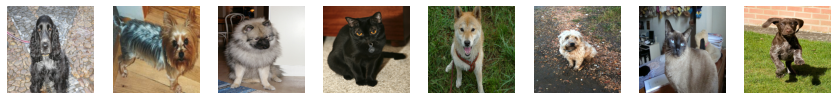

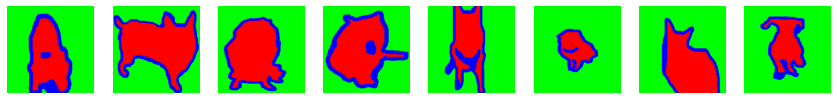

>> Predictions:


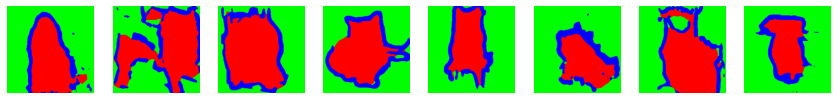

In [25]:
images, masks = next(iter(test_loader))
preds = model.predict(images)

images = images.numpy().astype(int)
masks = masks.numpy()
preds = preds.round()
# preds = softmax(preds).argmax(axis=-1)

n_samples = 8
print(">> Ground Truth:")
show_images(images[:n_samples], n_cols=n_samples)
show_images(masks[:n_samples], n_cols=n_samples)

print(">> Predictions:")
show_images(preds[:n_samples], n_cols=n_samples)